# Fig04_Draft-analysis
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 19.12.2019
    Date last modified: 19.12.2019

    ##############################################################
    Purpos:

    1) Reads in vertical windspeed from one case MCS

    2) plot a representative slice of vertical windspeeds
    
    3) Read in statistical evaluation of simulate draft characteristics


In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
# import shapely.geometry
# import descartes
import shapefile
import math
from scipy.stats.kde import gaussian_kde
from math import radians, cos, sin, asin, sqrt
from scipy import spatial
import matplotlib.path as mplPath
from pylab import *
from scipy.optimize import curve_fit
import scipy
import math
import SkewT
from scipy.interpolate import interp1d
# from astropy.io import ascii

In [2]:
################################################################################
################################################################################
#                            Settings

rgrGridSpacing=['12000','12000nc','4000','2000','1000','500','250']
rgrDX=[12000,12000,4000,2000,1000,500,250]
sSimDir='/glade/p/mmm/c3we/Idealized_MCSs/data/WRF/'

rgsSimulation=['03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5']

iEvents=10 # number of events that will be considered

sPlotDir='/glade/u/home/prein/papers/Idealized-MCSs/plots/Fig04_Drafts/'

rgiDomSize=[51,51,155,311,623,1247,2495]
iOutInt=12 # slizes per hour
ihours=7 # runtime in hours
iSkipH=3 # hours that should be excluded from the simulation
iRadPmax=60000. # m
iRadVol=100000. # m for the volume calculation

### Load example updraft field

In [3]:
grMaxPRall={}
iTT=20
for si in range(len(rgsSimulation)):
    grSimPR={}
    print '    Process '+rgsSimulation[si]
    for dx in range(len(rgrGridSpacing)):
        print '        Process '+rgrGridSpacing[dx]
        iDgc=int(12000./float(rgrDX[dx]))
        iRadGC=int(iRadPmax/float(rgrDX[dx])/2.)+iDgc
        iVolRad=int(iRadVol/float(rgrDX[dx]))
        # read in the precipiation variables
        rgrWact=np.zeros((ihours*iOutInt,rgiDomSize[dx], rgiDomSize[dx])); rgrWact[:]=np.nan
        for hh in [4]: #range(ihours):
            for tt in [8]: #range(iOutInt):
                if rgrGridSpacing[dx] != '250':
                    sFileAct=sSimDir+rgsSimulation[si]+'/'+rgrGridSpacing[dx]+'/wrfout_d01_0001-01-01_'+str("%02d" % hh)+':'+str("%02d" % (tt*5))+':*'
                else:
                    sFileAct=sSimDir+rgsSimulation[si]+'/'+rgrGridSpacing[dx]+'/Combined/wrfout_d01_2000-01-01_'+str("%02d" % hh)+':'+str("%02d" % (tt*5))+':*'
                try:
                    sFileAct=glob.glob(sFileAct)[0]
                    ncid=Dataset(sFileAct, mode='r') # open the netcdf file
                except:
                    stop()
                    
                # load W at 5 km heigh
                try:
                    rgrWact[hh*iOutInt+tt,:,:]=np.squeeze(ncid.variables['W'])[20,:,:]
                except:
                    stop()

        # select W time slize
        rgrWsel=rgrWact[iSkipH*iOutInt+iOutInt+iTT-12,:,:]
        grMaxPRall[str(rgrGridSpacing[dx])+'_W']=rgrWsel

    Process 03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
        Process 12000
        Process 12000nc
        Process 4000
        Process 2000
        Process 1000
        Process 500
        Process 250


### Load average vertical velocities vs height plots

In [4]:
rgsSimulations=['19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '23_2007-06-19_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '10_2009-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '13_2003-08-30_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '17_2011-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '18_2010-06-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '38_2007-08-04_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '46_2009-06-14_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '07_2011-07-04_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',

                '64_2012-06-17_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '58_2009-06-08_PGW_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5',
                '41_2005-06-10_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '68_2013-07-07_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '31_2006-08-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '16_2002-06-11_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '34_2010-07-12_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '51_2003-06-23_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '56_2008-06-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5',
                '35_2004-07-02_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5']
sGrid='12km'
rgsStats=['Upward Massflux Diff.', 'Downward Massflux Diff.']
Stat='MEAN'
rgrMassFLX=np.zeros((2,len(rgsSimulations),len(rgrGridSpacing),5,95)); rgrMassFLX[:]=np.nan
MassFluxAll=np.zeros((2,len(rgsSimulations),len(rgrGridSpacing),95,50)); MassFluxAll[:]=np.nan
for si in range(len(rgsSimulations)):
    print '    Load '+rgsSimulations[si]
    grDATA={}
    for dx in range(len(rgrGridSpacing)):
        try:
            fname='/glade/scratch/prein/Papers/Idealized_MCSs/data/MCS-VertMassFlux/'+sGrid+'/'+rgsSimulations[si]+'_'+rgrGridSpacing[dx]+'m_Smooth-36000_'+sGrid+'-grid'+Stat+'.pkl'
            grDATA[rgrGridSpacing[dx]]=pickle.load( open( fname, "rb" ) )['0']
        except:
            continue
    try:
        grRef=grDATA['250']
    except:
        stop()
    for dx in range(len(rgrGridSpacing)-1):
        try:
            grMod=grDATA[rgrGridSpacing[dx]]
        except:
            continue

        # calculate mean PR diff.
        rgrRef_UFLX=grRef['Upw_FLX']; rgrRef_UFLX[rgrRef_UFLX == 0]=np.nan
        rgrMod_UFLX=grMod['Upw_FLX']; rgrMod_UFLX[rgrMod_UFLX == 0]=np.nan
        if len(rgrRef_UFLX[0,:]) != len(rgrMod_UFLX[0,:]):
            Smaller=np.min([len(rgrRef_UFLX[0,:]),len(rgrMod_UFLX[0,:])])
            rgrRef_UFLX=rgrRef_UFLX[:,:Smaller]
            rgrMod_UFLX=rgrMod_UFLX[:,:Smaller]
        # rgrMassFLX[0,si,dx,:,:]=((np.nanpercentile(rgrMod_UFLX, (0,25,50,75,100),axis=1)-np.nanpercentile(rgrRef_UFLX, (0,25,50,75,100),axis=1))/np.nanpercentile(rgrRef_UFLX, (0,25,50,75,100),axis=1))*100
        rgrMassFLX[0,si,dx,:,:]=np.nanpercentile((rgrMod_UFLX-rgrRef_UFLX)/rgrRef_UFLX, (0,25,50,75,100),axis=1)*100
        rgrRef_DFLX=grRef['Dnw_FLX']; rgrRef_DFLX[rgrRef_DFLX == 0]=np.nan
        rgrMod_DFLX=grMod['Dnw_FLX']; rgrMod_DFLX[rgrMod_DFLX == 0]=np.nan
        if len(rgrRef_DFLX[0,:]) != len(rgrMod_DFLX[0,:]):
            Smaller=np.min([len(rgrRef_DFLX[0,:]),len(rgrMod_DFLX[0,:])])
            rgrRef_DFLX=rgrRef_DFLX[:,:Smaller]
            rgrMod_DFLX=rgrMod_DFLX[:,:Smaller]
        rgrMassFLX[1,si,dx,:,:]=np.nanpercentile((rgrMod_DFLX-rgrRef_DFLX)/rgrRef_DFLX, (0,25,50,75,100),axis=1)*100

        MassFluxAll[0,si,dx,:,:rgrMod_UFLX.shape[1]]=rgrMod_UFLX
        MassFluxAll[1,si,dx,:,:rgrMod_DFLX.shape[1]]=rgrMod_DFLX
    MassFluxAll[0,si,6,:,:rgrRef_UFLX.shape[1]]=rgrRef_UFLX
    MassFluxAll[1,si,6,:,:rgrRef_DFLX.shape[1]]=rgrRef_DFLX

# calculate if samples are significantly different
MannWithney_P=np.zeros((2,2,len(rgrGridSpacing),95)); MannWithney_P[:]=np.nan
for dx in range(len(rgrGridSpacing)):
    for hh in range(95):
        MannWithney_P[0,0,dx,hh]=scipy.stats.wilcoxon(np.nanmean(MassFluxAll[0,:10,dx,hh,:], axis=1),np.nanmean(MassFluxAll[0,:10,-1,hh,:], axis=1))[1]
        MannWithney_P[1,0,dx,hh]=scipy.stats.wilcoxon(np.nanmean(MassFluxAll[1,:10,dx,hh,:], axis=1),np.nanmean(MassFluxAll[1,:10,-1,hh,:], axis=1))[1]
        MannWithney_P[0,1,dx,hh]=scipy.stats.wilcoxon(np.nanmean(MassFluxAll[0,-10:,dx,hh,:], axis=1),np.nanmean(MassFluxAll[0,-10:,-1,hh,:], axis=1))[1]
        MannWithney_P[1,1,dx,hh]=scipy.stats.wilcoxon(np.nanmean(MassFluxAll[1,-10:,dx,hh,:], axis=1),np.nanmean(MassFluxAll[1,-10:,-1,hh,:], axis=1))[1]


    Load 19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 23_2007-06-19_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5


/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1172: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


    Load 10_2009-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 13_2003-08-30_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 17_2011-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 18_2010-06-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 38_2007-08-04_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 46_2009-06-14_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 07_2011-07-04_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 64_2012-06-17_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 58_2009-06-08_PGW_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 41_2005-06-10_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 68_2013-07-07_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 31_2006-08-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 16_2002-06-11_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 34_2010-07-12_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 51_2003-06-23_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 56_2008-06-18_PGW_Midwes

/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: Mean of empty slice
/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/scipy/stats/morestats.py:2388: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/scipy/stats/morestats.py:2389: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)
/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice
/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: Mean of empty slice
/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/si

### Load Core Geometry Analysis

The geometry and dynamics analysis comes from:

/gpfs/u/home/prein/papers/Idealized-MCSs/programs/CoreProperties/CoreProperties.py


In [5]:
rgrMeanWidth=np.zeros((2,len(rgsSimulations),len(rgrGridSpacing),101)); rgrMeanWidth[:]=np.nan
rgrMeanDepth=np.copy(rgrMeanWidth)
rgrMeanVol=np.copy(rgrMeanWidth)
rgsStats=['Wmean','WP95','Wdepth','Wwidth','WwidthMax','Wvolume']

rgrWMean=np.zeros((2,len(rgsSimulations),len(rgrGridSpacing),101)); rgrWMean[:]=np.nan
rgrWP95=np.copy(rgrWMean)
rgsStatsW=['Wmean','WP95','Wdepth','Wwidth','WwidthMax','Wvolume']

for si in range(len(rgsSimulations)):
    print '    Load '+rgsSimulations[si]
    grDATA={}
    grDATAW={}
    for dx in range(len(rgrGridSpacing)):
        try:
            fname='/glade/scratch/prein/Papers/Idealized_MCSs/data/3D_Cores/'+rgsSimulations[si]+'_'+rgrGridSpacing[dx]+'m_Sigm-0.0_Random-50_MinSpeed-3.npz'
            grDATA[rgrGridSpacing[dx]]=np.load( open( fname, "rb" ) )['rgrObAll']
            fname=sDataDir+rgsSimulations[si]+'_'+rgrGridSpacing[dx]+'m_Sigm-0.0_Random-50_MinSpeed-3.npz'
            grDATAW[rgrGridSpacing[dx]]=np.load( open( fname, "rb" ) )['rgrObAll']
        except:
            continue
    for dx in range(len(rgrGridSpacing)):
        try:
            Data_Act=grDATA[rgrGridSpacing[dx]]
        except:
            continue
        # calculate geometry
        rgrMeanWidth[0,si,dx,:]=np.nanpercentile(Data_Act[rgsStats.index('Wwidth'),0,:], range(101))
        rgrMeanWidth[1,si,dx,:]=np.nanpercentile(Data_Act[rgsStats.index('Wwidth'),1,:], range(101))
        rgrMeanDepth[0,si,dx,:]=np.nanpercentile(Data_Act[rgsStats.index('Wdepth'),0,:], range(101))
        rgrMeanDepth[1,si,dx,:]=np.nanpercentile(Data_Act[rgsStats.index('Wdepth'),1,:], range(101))
        rgrMeanVol[0,si,dx,:]=np.nanpercentile(Data_Act[rgsStats.index('Wvolume'),0,:], range(101))
        rgrMeanVol[1,si,dx,:]=np.nanpercentile(Data_Act[rgsStats.index('Wvolume'),1,:], range(101))
        
        # calculate dynamics
        rgrWMean[0,si,dx,:]=np.nanpercentile(Data_Act[rgsStatsW.index('Wmean'),0,:], range(101))
        rgrWMean[1,si,dx,:]=np.nanpercentile(Data_Act[rgsStatsW.index('Wmean'),1,:], range(101))
        rgrWP95[0,si,dx,:]=np.nanpercentile(Data_Act[rgsStatsW.index('WP95'),0,:], range(101))
        rgrWP95[1,si,dx,:]=np.nanpercentile(Data_Act[rgsStatsW.index('WP95'),1,:], range(101))

    Load 19_2011-07-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 03_2011-07-16_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 23_2007-06-19_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 10_2009-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 13_2003-08-30_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 17_2011-06-27_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5


/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


    Load 18_2010-06-13_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 38_2007-08-04_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 46_2009-06-14_CTRL_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 07_2011-07-04_CTRL_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 64_2012-06-17_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 58_2009-06-08_PGW_Midwest_-Loc2_MCS_Storm-Nr_JJA-8-TH5
    Load 41_2005-06-10_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 68_2013-07-07_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 31_2006-08-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 16_2002-06-11_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 34_2010-07-12_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 51_2003-06-23_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 56_2008-06-18_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5
    Load 35_2004-07-02_PGW_Midwest_-Loc1_MCS_Storm-Nr_JJA-8-TH5


## Plotting

/gpfs/u/apps/dav/opt/python/2.7.14/intel/17.0.1/pkg-library/20180510/lib/python2.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: Mean of empty slice


        Plot map to: /glade/u/home/prein/papers/Idealized-MCSs/plots/Fig04_Drafts/Fig04_Draft-comparison_CTR.pdf


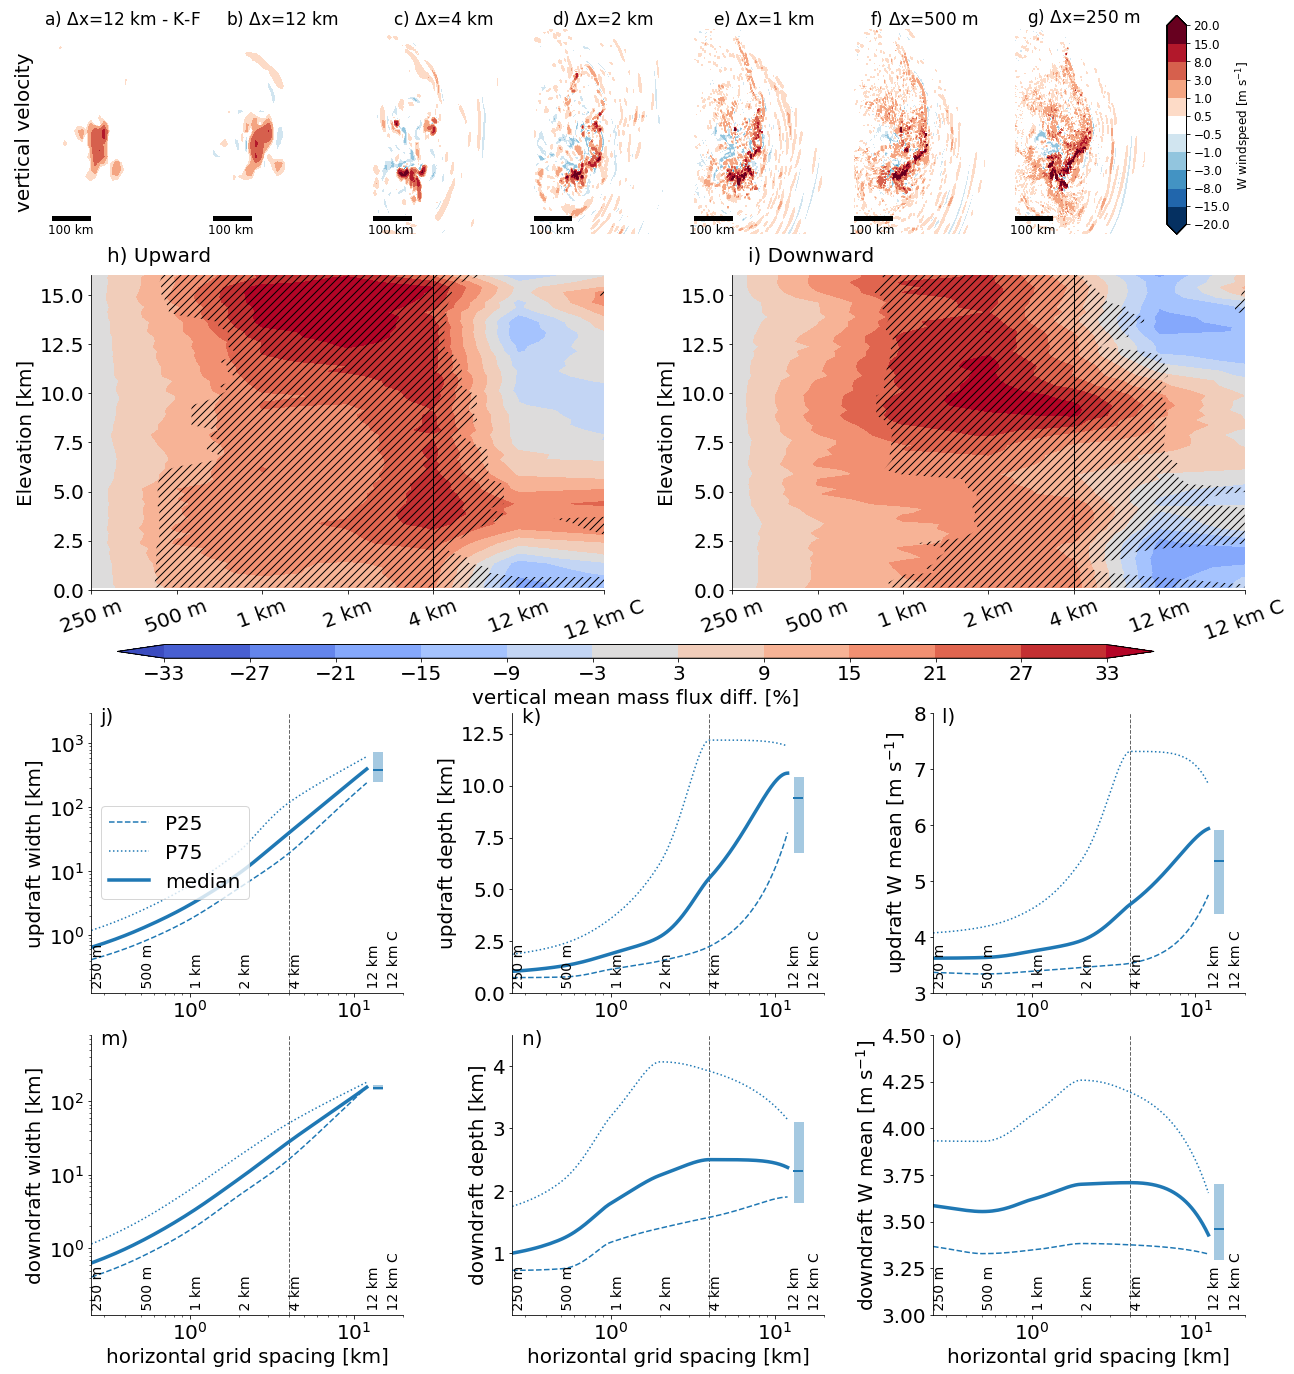

In [9]:
# set the font size
plt.rcParams.update({'font.size': 15})
rgsLableABC=list(string.ascii_lowercase)

fig = plt.figure(figsize=(18,19))
plt.rcParams.update({'font.size': 20})
gs1 = gridspec.GridSpec(1,len(rgrGridSpacing))
gs1.update(left=0.05, right=0.9,
           bottom=0.83, top=0.98,
           wspace=0.15, hspace=0.3)

nws_W_colors = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#ffffff','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061'][::-1]
cStep=2.
levelsW = [-20.,  -15.,  -8.,  -3.,  -1.,  -0.5,   0.5,   1.,   3.,   8.,   15., 20.] #(np.array(range(len(nws_W_colors)+1))/float(len(nws_W_colors))-0.5)*cStep*len(nws_W_colors)

for dx in range(len(rgrGridSpacing)):
    rgrWact=grMaxPRall[str(rgrGridSpacing[dx])+'_W']
    rgrAxis=np.linspace(0,rgrWact.shape[0]*float(rgrDX[dx]),rgrWact.shape[0])/1000.
    ax = plt.subplot(gs1[0,dx])
    ax.axis('off')
    if dx == 0:
        ax.text(-0.2,0.5, 'vertical velocity', ha='center', va='center', fontsize=20,transform = ax.transAxes, rotation=90) #, fontweight='bold')
    # plt W field
    cs = ax.contourf(rgrAxis, rgrAxis,rgrWact, levels=levelsW, colors=nws_W_colors, extend='both',zorder = 1)
    cs.cmap.set_over("#67001f")  
    sCBlabel='W windspeed [m s$^{-1}$]' 
    TicksCB=levelsW

    # plot a line for scale reference
    ax.plot([260,360],[30,30],lw=5, c='k')
    ax.text(310,20,'100 km', ha='center', va='top', fontsize=12)

    if rgrGridSpacing[dx] == '250':
        ax.text(0.5,1, rgsLableABC[dx]+') $\Delta$x='+str(250)+' m', ha='center', va='bottom', 
                fontsize=17,transform = ax.transAxes) #, fontweight='bold')
    elif rgrGridSpacing[dx] == '500':
        ax.text(0.5,1, rgsLableABC[dx]+') $\Delta$x='+str(500)+' m', ha='center', va='bottom', 
                fontsize=17,transform = ax.transAxes) #, fontweight='bold')
    else:
        if rgrGridSpacing[dx] == '12000':
            # use of cumulus scheme
            ax.text(0.5,1,rgsLableABC[dx]+') $\Delta$x='+str(int(float(rgrDX[dx])/1000.))+' km - K-F', ha='center', va='bottom', 
                    fontsize=17,transform = ax.transAxes) #, fontweight='bold')
        else:
            ax.text(0.5,1,rgsLableABC[dx]+') $\Delta$x='+str(int(float(rgrDX[dx])/1000.))+' km', ha='center', va='bottom', 
                    fontsize=17,transform = ax.transAxes) #, fontweight='bold')
    plt.grid()
    ax.set_ylim([0,390])
    ax.set_xlim([260,650])
    ax.axis('off')        

    # add colorbar
    pos1 = ax.get_position()
    CbarAx = axes([0.91,0.83, 0.015, 0.16])
    cb = colorbar(cs, cax = CbarAx, orientation='vertical', extend='max', ticks=TicksCB) #, ticks=np.linspace(0,120,13))
    cb.set_label(label=sCBlabel,size=12)
    cb.ax.tick_params(labelsize=12)
    


# ------------------------------------
# Plot vertical mass flux differences

gs1 = gridspec.GridSpec(1,2)
gs1.update(left=0.08, right=0.97,
           bottom=0.57, top=0.8,
           wspace=0.25, hspace=0.25)

rgsColors=['k','#e31a1c']
rgsPeriods=['Upward','Downward']
for tp in range(2):
    if tp == 0:
        Period='Upward'
        DATA=rgrMassFLX[0,:10,:,2,:]
    else:
        Period='Downward'
        DATA=rgrMassFLX[1,:10,:,2,:]
    st=0
    ax = plt.subplot(gs1[0,tp])
    
    PlotData=np.transpose(np.nanmean(DATA, axis=(0))); PlotData[np.isnan(PlotData)]=0
    Levels=np.linspace(-33,33,12)
    cs=plt.contourf(range(7)[::-1], np.array(grRef['levels'])/1000., PlotData, levels=Levels, extend='both', cmap='coolwarm')
    csH=plt.contourf(range(7)[::-1], np.array(grRef['levels'])/1000., np.transpose(MannWithney_P[st,tp,:,:]), 
                     levels=[0,0.05,1],hatches=['///',None], facecolor="none",fill=False, colors='none')

    xx = range(7) #[0.5,1.5, 2.5, 3.5,4.5,5.5,6.5]
    labels = [ '12 km C',  '12 km',  '4 km', '2 km','1 km','500 m', '250 m']
    plt.xticks(xx, labels[::-1], rotation=20)
    ax.set_ylabel('Elevation [km]')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(0, 6)
    plt.axhline(y=0, c='k', lw=1)
    plt.ylim(0,16)
    ax.axvline(x=4, ls='-', c='k', zorder=10, alpha=1, lw=1)

    ax.text(0.03,1.03, rgsLableABC[tp+7]+') '+Period, ha='left',va='bottom', \
            transform = ax.transAxes, fontname="Times New Roman Bold") #, fontsize=17)
    # add colorbar
    CbarAx = axes([0.10,0.52, 0.8, 0.01])
    cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both', label='vertical mean mass flux diff. [%]', ticks=Levels)
    

# ------------------------------------
# Plot core geometry

gs1 = gridspec.GridSpec(2,3)
gs1.update(left=0.08, right=0.97,
           bottom=0.04, top=0.48,
           wspace=0.35, hspace=0.15)

rgsColors=['k','#e31a1c']
rgsPeriods=['CUR','FUT']
rgsStatsSel=['Wwidth','Wdepth', 'Wmean'] #,'Wvolume']
UpDown=['updraft','downdraft']

for ud in range(2):
    for st in range(len(rgsStatsSel)):
        ax = plt.subplot(gs1[ud,st])
        if rgsStatsSel[st] == 'Wwidth':
            DATA=rgrMeanWidth[ud,:,:,:]
            Yrange=[[0.125,3000],[0.125,800]]
            Label='width [km]'
        if rgsStatsSel[st] == 'Wdepth':
            DATA=rgrMeanDepth[ud,:,:,:]
            Yrange=[[0.01,13.5],[0.01,4.5]]
            Label='depth [km]'
        if rgsStatsSel[st] == 'Wvolume':
            DATA=rgrMeanVol[ud,:,:,:]
            Yrange=[[0.09,30000],[0.09,1000]]
            Label='volume [km$^3$]'
        if rgsStatsSel[st] == 'Wmean':
            DATA=rgrWMean[ud,:,:,:]
            Yrange=[[3,8],[3,4.5]]
            Label='W mean [m s$^{-1}$]'

        Xaxis=np.round(np.arange(0.25,12.025,0.025),3)
        RealPoints=[np.where(Xaxis == np.array(rgrDX[ii]).astype('float')/1000.)[0][0] for ii in range(len(rgrDX))]
        DATA_pe=np.nanmean(DATA[:10,:,:], axis=0)
        col='#1f78b4'
        
        # plot qartile range
        P25=np.copy(Xaxis); P25[:]=np.nan; P25[RealPoints[1:]]=DATA_pe[1:,25]
        s25 = pd.Series(P25)
        P75=np.copy(Xaxis); P75[:]=np.nan; P75[RealPoints[1:]]=DATA_pe[1:,75]
        s75 = pd.Series(P75)
        ax.plot(Xaxis,s25.interpolate(method='pchip'), c=col, ls='--', label='P25')
        ax.plot(Xaxis,s75.interpolate(method='pchip'), c=col, ls=':', label='P75')
        # plot median
        ii=50
        DataInt=np.copy(Xaxis); DataInt[:]=np.nan; DataInt[RealPoints[1:]]=DATA_pe[1:,ii]
        s = pd.Series(DataInt)
        plt.plot(Xaxis, s.interpolate(method='pchip'), c=col, lw=3.5, alpha=1, label='median')
        # plot the 12 km simulation with cumulus scheme as box wisker plot
        plt.plot([14,14],[DATA_pe[0,25],DATA_pe[0,75]] , c=col, lw=10, alpha=0.4,solid_capstyle="butt")
#         plt.plot([14+pe*4,14+pe*4],[DATA_pe[0,10],DATA_pe[0,25]] , c=col, lw=3, alpha=0.2,solid_capstyle="butt")
#         plt.plot([14+pe*4,14+pe*4],[DATA_pe[0,75],DATA_pe[0,90]] , c=col, lw=3, alpha=0.2,solid_capstyle="butt")
        plt.plot([13.2,14.8],[DATA_pe[0,50],DATA_pe[0,50]] , c=col, lw=2, alpha=1)

        xx = [16,12, 4, 2,1,0.5,0.25]
        labels = np.array([ '12 km C',  '12 km',  '4 km', '2 km','1 km','500 m', '250 m'])
        for dx in range(len(xx)):
            if xx[dx] == 4:
                ax.axvline(x=xx[dx], ls='--', c='k', zorder=0, alpha=0.6, lw=1)
            ax.text(xx[dx],Yrange[ud][0], ' '+labels[dx], ha='left',va='bottom', \
                    fontname="Times New Roman Bold", rotation=90, fontsize=14)
        
        plt.xticks(xx, labels, rotation=0)
        ax.get_xaxis().get_major_formatter().labelOnlyBase = False

        ax.set_ylabel(UpDown[ud]+' '+Label)
        if ud == 1:
            ax.set_xlabel('horizontal grid spacing [km]')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlim(0.25, 20)
        plt.axhline(y=0, c='k', lw=0.5)
        plt.ylim(Yrange[ud][0],Yrange[ud][1])
        if (rgsStatsSel[st] != 'Wdepth') & (rgsStatsSel[st] != 'Wmean'):
            ax.set_yscale('log')
        ax.set_xscale('log')
        
        if (st == 0) & (ud == 0):
            plt.legend(loc="center left",
                       ncol=1, prop={'size':20})

        ax.text(0.03,0.95, rgsLableABC[st+ud*3+9]+') ', ha='left',va='bottom', \
                transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=20)
    
# Plot the figure
sPlotFile=sPlotDir
sPlotName= 'Fig04_Draft-comparison_CTR.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print '        Plot map to: '+sPlotFile+sPlotName
fig.savefig(sPlotFile+sPlotName)